In [1]:
from scipy.optimize import linear_sum_assignment
from ot import sinkhorn

In [2]:

import numpy as np
import time
# from sklearn.utils import check_random_state

def alap(P, n, maximize, reg, tol):
    
    power = -1 if maximize else 1
    lamb = reg / np.max(np.abs(P))
    ones = np.ones(n)
    P_eps = sinkhorn(ones, ones, P, power/lamb, stopInnerThr=tol,numItermax=1000) # * (P > np.log(1/n)/lamb)

    
    return P_eps

nodes = np.arange(250, 3250, 250).astype(int)
reps = 100
times_lap = np.zeros((len(nodes),reps))
times_ot = np.zeros((len(nodes),reps))
score_lap = np.zeros((len(nodes),reps))
score_ot = np.zeros((len(nodes),reps))
reg = 400
tol = 1e-2
for i, n in enumerate(nodes):
    for t in range(reps):
        M = np.random.uniform(100,150, (n,n))
        maximize = False
        start = time.time()
        res = linear_sum_assignment(M, maximize)
        times_lap[i,t] = time.time()-start
        score_lap[i,t] = M[res].sum()

        start = time.time()
        Q = alap(M, n, maximize, reg, tol)
        times_ot[i,t] = time.time()-start
        score_ot[i,t] = np.trace(Q.T@M)
    

# LAP VS LOT runtime and performance figure
## Caption: 
Running time and performance of LAP and LOT as a function of number of nodes, $n$. Cost matrix sampled from a Uniform(100, 150) distribution, with 100 simulations per $n$. Performance defined as relative accuracy, $OFV_{LAP} - OFV_{LOT} \over OFV_{LAP}$, with each dot representing a single simulation.



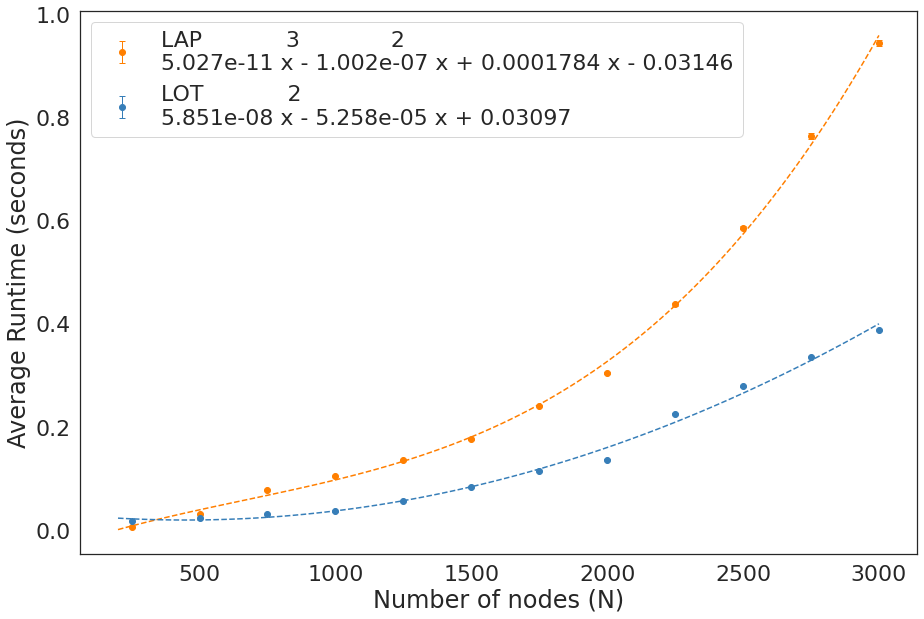

In [3]:

import matplotlib.pyplot as plt
from scipy.stats import sem
import seaborn as sns
cb = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plap = np.poly1d(np.polyfit(nodes,np.mean(times_lap, axis=1),3))
pot = np.poly1d(np.polyfit(nodes,np.mean(times_ot, axis=1),2))
xp = np.linspace(200, 3000, 100)
sns.set_context('paper')
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 2)
sns.set_style('white')

plt.errorbar(nodes,np.mean(times_lap, axis=1), sem(times_lap, axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label=f'LAP {plap}',color=cb[1])
plt.errorbar(nodes,np.mean(times_ot, axis=1), sem(times_ot, axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label=f'LOT {pot}',color=cb[0])
plt.plot(xp,plap(xp), '--',color=cb[1],)
plt.plot(xp,pot(xp),'--',color=cb[0])

plt.xlabel("Number of nodes (N)")

plt.ylabel("Average Runtime (seconds)")
plt.legend()

Text(0, 0.5, 'Objective Function Relative Difference')

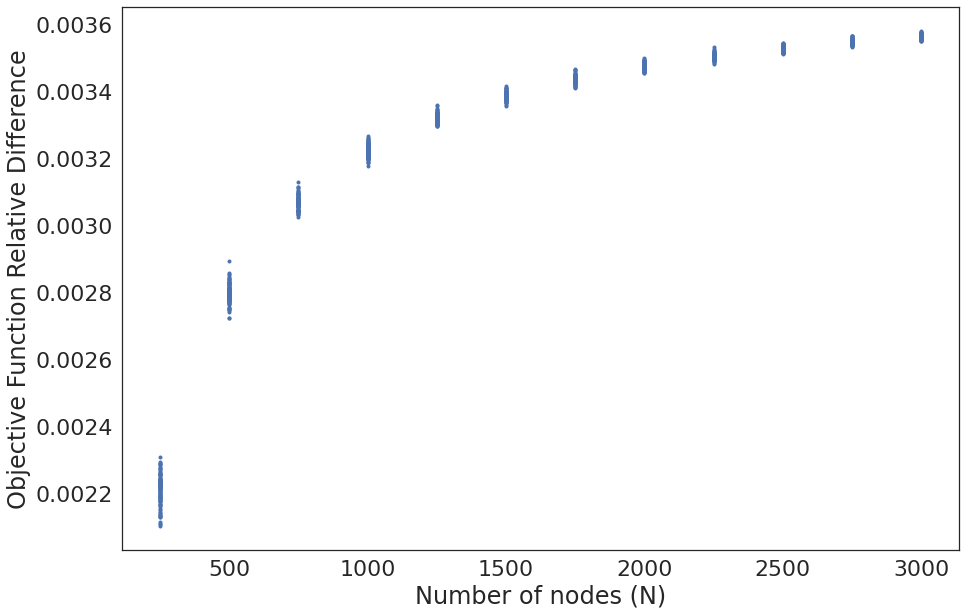

In [4]:
# plt.errorbar(nodes,np.mean(score_lap, axis=1), sem(score_lap, axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label=f'LAP {plap}',color='red')
# plt.errorbar(nodes,np.mean(score_ot, axis=1), sem(score_ot, axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label=f'OT {pot}',color='blue')
pdiff = abs(score_lap-score_ot)/score_lap
plt.scatter(np.tile(nodes, reps).reshape((reps, len(nodes))).T, pdiff, marker='.')
# plt.hlines(np.max(pdiff),np.min(nodes),np.max(nodes),linestyles='dashed', color = 'red')
plt.xlabel("Number of nodes (N)")
plt.ylabel("Objective Function Relative Difference")


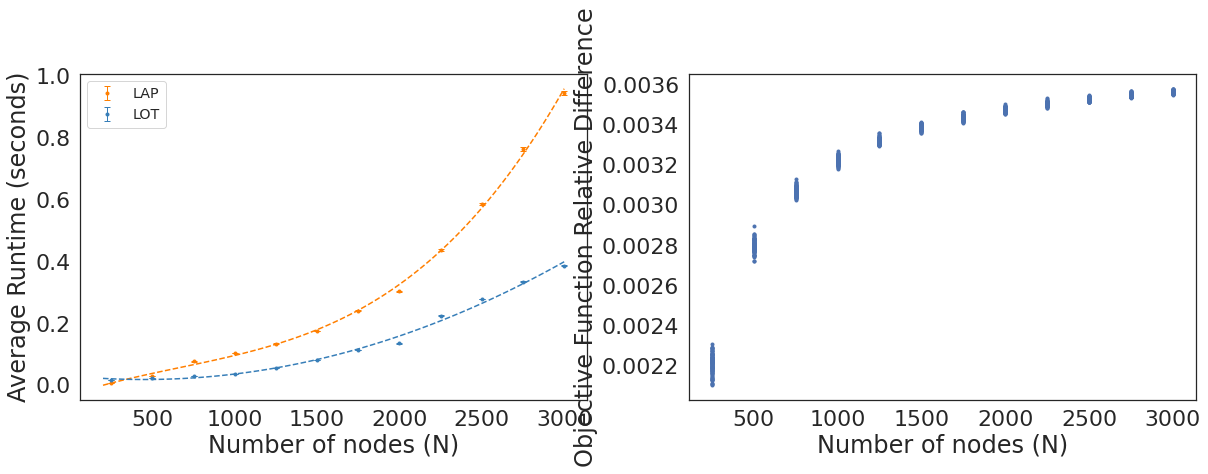

In [5]:

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.set_context('paper')
# sns.set(rc={'figure.figsize':(15,20)})
sns.set(font_scale = 1.3)
sns.set_style('white')

ax[0].errorbar(nodes,np.mean(times_lap, axis=1), sem(times_lap, axis=1),fmt='.',capsize=3, elinewidth=1, markeredgewidth=1, label=f'LAP', color=cb[1])
ax[0].errorbar(nodes,np.mean(times_ot, axis=1), sem(times_ot, axis=1),fmt='.',capsize=3, elinewidth=1, markeredgewidth=1, label=f'LOT', color=cb[0])
ax[0].plot(xp,plap(xp), '--',color=cb[1],)
ax[0].plot(xp,pot(xp),'--',color=cb[0])
sns.set(font_scale = 1.3)
sns.set_style('white')
ax[0].set_xlabel("Number of nodes (N)")

ax[0].set_ylabel("Average Runtime (seconds)")
ax[0].legend()
pdiff = abs(score_lap-score_ot)/score_lap #* 100
ax[1].scatter(np.tile(nodes, reps).reshape((reps, len(nodes))).T, pdiff, marker='.')
# ax[1].set_yscale("log")
# plt.hlines(np.max(pdiff),np.min(nodes),np.max(nodes),linestyles='dashed', color = 'red')
sns.set(font_scale = 1.3)
sns.set_style('white')
ax[1].set_xlabel("Number of nodes (N)")
ax[1].set_ylabel("Objective Function Relative Difference")
plt.savefig('lapvlot.png')